<a href="https://colab.research.google.com/github/chamuditha00/BrainCancerDetection/blob/main/brainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#unzip
!unzip /content/drive/MyDrive/BrainTumorDataSet.zip

Archive:  /content/drive/MyDrive/BrainTumorDataSet.zip
   creating: Brain Tumor Data Set/Brain Tumor/
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (1002).JPG  
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (1003).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (1004).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (1005).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (1006).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor/Cancer (

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [5]:
#count the number of images in the respective classes 0 - glioma 1- meningioma 2-notumor 3- pitutary

ROOT_DIR = "/content/Brain Tumor Data Set"

number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))



number_of_images.items()

dict_items([('Healthy', 2087), ('Brain Tumor', 2513)])

In [6]:
# create a training folder
def splitdata(path , size):

  if not os.path.exists("./"+path):
    os.mkdir("./"+path)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+path+"/"+dir)
      for img in np.random.choice(a= os.listdir(os.path.join(ROOT_DIR,dir)),
                                size = (math.floor(size*number_of_images[dir])-5),
                                replace=False):
        o =os.path.join(ROOT_DIR,dir,img)
        d = os.path.join("./"+path, dir)
        shutil.copy(o,d)
        os.remove(o)
  else:
    print("the folder exists")

In [7]:
splitdata("Training" , 0.7)

In [8]:
splitdata("Validation",0.15)

In [9]:
splitdata("Testing",0.15)

In [10]:
from keras.layers import Conv2D, Dropout, Flatten , Dense , BatchNormalization , MaxPool2D, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
#CNN model (Convolutional Neural Network )

model = Sequential()

#hidden layers
model.add(Conv2D(filters = 16, kernel_size = (3,3),  activation = 'relu', input_shape= (224,224,3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),  activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),  activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),  activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [11]:
model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy,metrics= ['accuracy'])

In [12]:
def PreprocesssingImages(path):
  """
  input :path
  output:pre processed images
  """

  image_date = ImageDataGenerator(zoom_range=0.2, shear_range=0.2,rescale=1/255,horizontal_flip=True) #data augmantation
  image = image_date.flow_from_directory(directory=path, target_size=(224,224), batch_size=32, class_mode="binary")

  return image

In [13]:
def PreprocesssingImagestest(path):
  """
  input :path
  output:pre processed images
  """
  image_date = ImageDataGenerator(rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,zoom_range=0.2, shear_range=0.2,rescale=1/255,horizontal_flip=True) #data augmantation
  image = image_date.flow_from_directory(directory=path, target_size=(224,224), batch_size=32, class_mode="binary")

  return image

In [14]:
path= "/content/Training"
train_data = PreprocesssingImages(path)

Found 3209 images belonging to 2 classes.


In [15]:
path= "/content/Validation"
val_data = PreprocesssingImagestest(path)

Found 679 images belonging to 2 classes.


In [16]:
path= "/content/Testing"
test_data = PreprocesssingImagestest(path)

Found 679 images belonging to 2 classes.


In [17]:
#early stopping and model check point
from keras.callbacks import ModelCheckpoint , EarlyStopping

es = EarlyStopping(monitor= "val_accuracy",min_delta=0.01, patience = 3 , verbose=1, mode = 'auto')

#check point
cp = ModelCheckpoint(monitor = 'val_accuracy', filepath="./bestmodel.h5", verbose=1,save_best_only=True, mode='auto')

cd = [es,cp]

In [18]:
hs = model.fit_generator(generator= train_data,
                         steps_per_epoch=8,epochs=30,verbose=1,validation_data=val_data, validation_steps=16,callbacks=cd)

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.8943 - accuracy: 0.4844
Epoch 1: val_accuracy improved from -inf to 0.53516, saving model to ./bestmodel.h5
8/8 [==============================] - 90s 11s/step - loss: 0.8943 - accuracy: 0.4844 - val_loss: 0.6940 - val_accuracy: 0.5352
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.6730 - accuracy: 0.6172
Epoch 2: val_accuracy improved from 0.53516 to 0.56055, saving model to ./bestmodel.h5
8/8 [==============================] - 87s 11s/step - loss: 0.6730 - accuracy: 0.6172 - val_loss: 0.6871 - val_accuracy: 0.5605
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.6016
Epoch 3: val_accuracy did not improve from 0.56055
8/8 [==============================] - 84s 11s/step - loss: 0.6796 - accuracy: 0.6016 - val_loss: 0.7184 - val_accuracy: 0.4414
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.6133
Epoch 4: val_accuracy did 

In [19]:
# Model grapic Interpretation

h = hs.history

h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

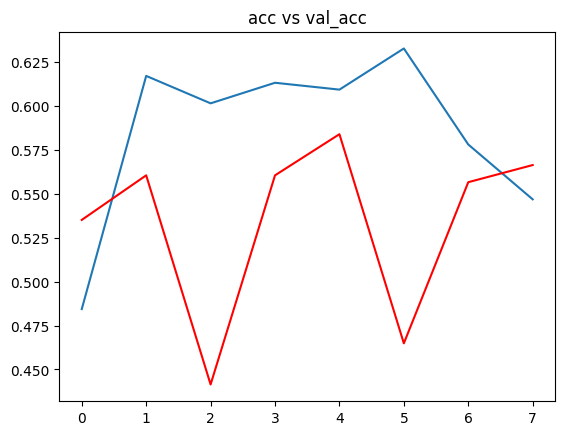

In [20]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")

plt.title("acc vs val_acc")
plt.show()

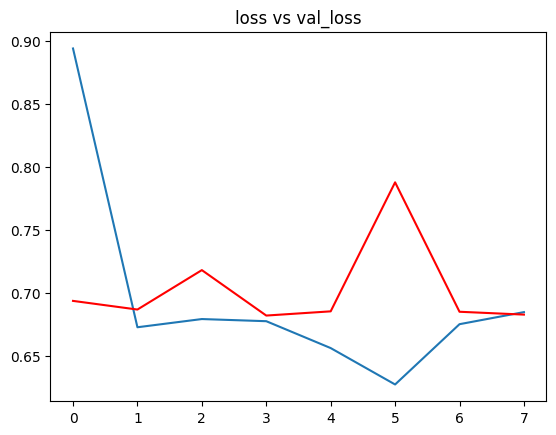

In [21]:
import matplotlib.pyplot as plt

plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")

plt.title("loss vs val_loss")
plt.show()

In [22]:
#model Accuracy

from keras.models import load_model

model = load_model("/content/bestmodel.h5")

In [23]:
acc = model.evaluate_generator(test_data)[1]

print(f"the accuracy of model is {acc*100}%")

the accuracy of model is 58.4683358669281%


In [24]:
from keras.preprocessing.image import load_img , img_to_array
import numpy as np
import math

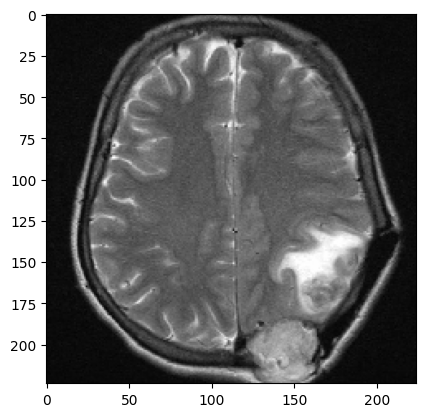

1/1 [==============================] - 0s 56ms/step
0.39387742
0


In [32]:
path = "/content/Testing/Brain Tumor/Cancer (1029).jpg"
img = load_img(path, target_size=(224,224))



input_arr = img_to_array(img)/255


plt.imshow(input_arr)
plt.show()

input_arr.shape

input_arr = np.expand_dims(input_arr, axis = 0)

pred = model.predict(input_arr)[0][0]
print(pred)
pred_class = np.argmax(pred)
print(pred_class)





In [27]:
train_data.class_indices

{'Brain Tumor': 0, 'Healthy': 1}